# 基于词向量的英汉翻译——“火炬上的深度学习"下第一次作业

在这个作业中，你需要半独立地完成一个英文到中文的单词翻译器

本文件是集智AI学园http://campus.swarma.org 出品的“火炬上的深度学习”第VI课的配套源代码

In [18]:
# 加载必要的程序包
# PyTorch的程序包
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# 数值运算和绘图的程序包
import numpy as np
import matplotlib.pyplot as plt
import matplotlib


# 加载机器学习的软件包，主要为了词向量的二维可视化
from sklearn.decomposition import PCA

#加载Word2Vec的软件包
import gensim as gensim
from gensim.models import Word2Vec
from gensim.models.keyedvectors import KeyedVectors
from gensim.models.word2vec import LineSentence

#加载正则表达式处理的包
import re

#在Notebook界面能够直接显示图形
%matplotlib inline

## 第一步：加载词向量

首先，让我们加载别人已经在大型语料库上训练好的词向量

In [19]:
# 加载中文词向量，下载地址为：链接：http://pan.baidu.com/s/1gePQAun 密码：kvtg
# 该中文词向量库是由尹相志提供，训练语料来源为：微博、人民日报、上海热线、汽车之家等，包含1366130个词向量
word_vectors = KeyedVectors.load_word2vec_format('vectors.bin', binary=True, unicode_errors='ignore')
len(word_vectors.vocab)

1366130

In [37]:
# 加载中文的词向量，下载地址为：http://nlp.stanford.edu/data/glove.6B.zip，解压后将glove.6B.100d.txt文件拷贝到与本notebook
# 文件一致的文件夹洗面。
f = open('glove.6B.100d.txt', 'r', encoding="utf8")
i = 1

# 将英文的词向量都存入如下的字典中
word_vectors_en = {}
with open('glove.6B.100d.txt', encoding="utf8") as f:
    for line in f:
        numbers = line.split()
        word = numbers[0]
        vectors = np.array([float(i) for i in numbers[1 : ]])
        word_vectors_en[word] = vectors
        i += 1
print(len(word_vectors_en))

400000


In [72]:
# 用gensim打开glove词向量需要在向量的开头增加一行：所有的单词数 词向量的维度
from sys import platform  
#计算行数，就是单词数
def getFileLineNums(filename):
    f = open(filename, 'r', encoding="utf8")
    count = 0
    for line in f:
        count += 1
    return count

#Linux或者Windows下打开词向量文件，在开始增加一行
def prepend_line(infile, outfile, line):
    with open(infile, 'r', encoding="utf8") as old:
        with open(outfile, 'w', encoding="utf8") as new:
            new.write(str(line) + "\n")
            shutil.copyfileobj(old, new)

def prepend_slow(infile, outfile, line):
    with open(infile, 'r', encoding="utf8") as fin:
        with open(outfile, 'w', encoding="utf8") as fout:
            fout.write(line + "\n")
            for line in fin:
                fout.write(line)

def load(filename):
    num_lines = getFileLineNums(filename)
    gensim_file = 'glove_model.txt'
    gensim_first_line = "{} {}".format(num_lines, 100)
    # Prepends the line.
    if platform == "linux" or platform == "linux2":
        prepend_line(filename, gensim_file, gensim_first_line)
    else:
        prepend_slow(filename, gensim_file, gensim_first_line)

    return KeyedVectors.load_word2vec_format(gensim_file, binary=False, unicode_errors='ignore', encoding="utf8")

#print(word_vectors_en['man']-word_vectors_en['woman'])
#print(word_vectors_en['king']-word_vectors_en['queen'])
#print((word_vectors_en['man']-word_vectors_en['woman'])-(word_vectors_en['king']-word_vectors_en['queen']))
word2vectors_en = load('glove.6B.100d.txt')  

In [73]:
words = word2vectors_en.most_similar(positive=['queen', 'king'], negative=['woman'])
print(words)

[('vi', 0.6533772349357605), ('prince', 0.632961630821228), ('vajiravudh', 0.616649866104126), ('coronation', 0.6091321706771851), ('monarch', 0.6082844734191895), ('throne', 0.5999543070793152), ('royal', 0.5951739549636841), ('majesty', 0.5917392373085022), ('kingdom', 0.5872225761413574), ('viii', 0.5812629461288452)]


In [74]:
words = word2vectors_en.most_similar(positive=['queen', 'king'], negative=['man'])
words

[('monarch', 0.635038435459137),
 ('vajiravudh', 0.6271814107894897),
 ('coronation', 0.6246286034584045),
 ('throne', 0.6243641376495361),
 ('consort', 0.6042282581329346),
 ('vi', 0.5987071394920349),
 ('prince', 0.5955268740653992),
 ('willem-alexander', 0.5946522951126099),
 ('kamehameha', 0.5892873406410217),
 ('majesty', 0.5889682769775391)]

In [75]:
words = word2vectors_en.most_similar(positive=['woman', 'man'], negative=['daughter'])
print(words)

[('person', 0.6981415748596191), ('one', 0.6729063391685486), ('another', 0.6447906494140625), ('turned', 0.6333966255187988), ('a', 0.6322406530380249), ('black', 0.6271578669548035), ('victim', 0.623831033706665), ('boy', 0.6224839091300964), ('kind', 0.6202846765518188), ('every', 0.6172523498535156)]


In [76]:
words = word2vectors_en.most_similar(positive=['woman', 'man'], negative=['son'])
words

[('girl', 0.6836705207824707),
 ('person', 0.6761190295219421),
 ('one', 0.6295770406723022),
 ('every', 0.6173022985458374),
 ('victim', 0.6168228983879089),
 ('female', 0.6135560274124146),
 ('she', 0.6130416393280029),
 ('women', 0.611282229423523),
 ('men', 0.6108694672584534),
 ('black', 0.6103718876838684)]

In [69]:
word2vectors_en.similarity("woman", "man")


0.83234941827580899

## 第二步：可视化同一组意思词在两种不同语言的词向量中的相互位置关系

In [21]:
# 中文的一二三四五列表
cn_list = {'一', '二', '三', '四', '五', '六', '七', '八', '九', '零'}
# 阿拉伯数字的12345列表
en_list = {'1', '2', '3', '4', '5', '6', '7', '8', '9', '0'}
# 英文数字的列表
en_list = {'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'zero'}

# 对应词向量都存入到列表中
cn_vectors = []  #中文的词向量列表
en_vectors = []  #英文的词向量列表
for w in cn_list:
    cn_vectors.append(word_vectors[w])
for w in en_list:
    en_vectors.append(word_vectors_en[w])

# 将这些词向量统一转化为矩阵
cn_vectors = np.array(cn_vectors)
en_vectors = np.array(en_vectors)

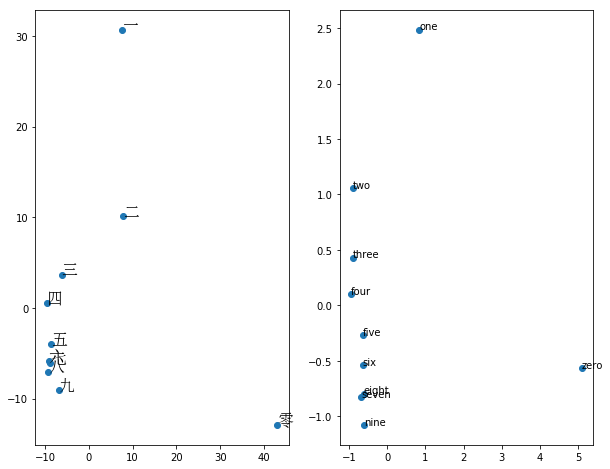

In [22]:
# 降维实现可视化
X_reduced = PCA(n_components=2).fit_transform(cn_vectors)
Y_reduced = PCA(n_components = 2).fit_transform(en_vectors)

# 绘制所有单词向量的二维空间投影
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 8))
ax1.plot(X_reduced[:, 0], X_reduced[:, 1], 'o')
ax2.plot(Y_reduced[:, 0], Y_reduced[:, 1], 'o')
#zhfont1 = matplotlib.font_manager.FontProperties(fname='/Library/Fonts/华文仿宋.ttf', size=16)
zhfont1 = matplotlib.font_manager.FontProperties(fname='C:/Windows/Fonts/simsun.ttc', size=16)
for i, w in enumerate(cn_list):
    ax1.text(X_reduced[i, 0], X_reduced[i, 1], w, fontproperties = zhfont1, alpha = 1)
for i, w in enumerate(en_list):
    ax2.text(Y_reduced[i, 0], Y_reduced[i, 1], w, alpha = 1)

### 结论：可以看出，中文的一、二、等数字彼此之间的关系与英文的数字彼此之间的关系很类似

In [28]:
# 中文动物列表
# 北美野牛
cn_list = {'马', '牛', '驴', '猫', '狗', '猫头鹰', '牦牛', '公牛', '牛犊', '天鹅'}
# 英文动物列表
# Bison Yak
en_list = {'horse', 'cow', 'donkey', 'cat', 'dog', 'owl', 'yak', 'ox', 'calf', 'cygnus'}

# 对应词向量都存入到列表中
cn_vectors = []  #中文的词向量列表
en_vectors = []  #英文的词向量列表
for w in cn_list:
    #print(word_vectors[w])
    cn_vectors.append(word_vectors[w])
for w in en_list:
    #print(word_vectors_en[w])
    en_vectors.append(word_vectors_en[w])

# 将这些词向量统一转化为矩阵
cn_vectors = np.array(cn_vectors)
en_vectors = np.array(en_vectors)

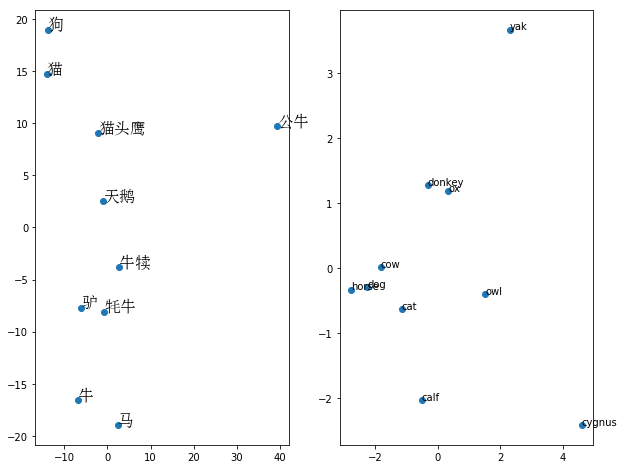

In [29]:
# 降维实现可视化
X_reduced = PCA(n_components=2).fit_transform(cn_vectors)
Y_reduced = PCA(n_components = 2).fit_transform(en_vectors)

# 绘制所有单词向量的二维空间投影
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 8))
ax1.plot(X_reduced[:, 0], X_reduced[:, 1], 'o')
ax2.plot(Y_reduced[:, 0], Y_reduced[:, 1], 'o')
#zhfont1 = matplotlib.font_manager.FontProperties(fname='/Library/Fonts/华文仿宋.ttf', size=16)
zhfont1 = matplotlib.font_manager.FontProperties(fname='C:/Windows/Fonts/simsun.ttc', size=16)
for i, w in enumerate(cn_list):
    ax1.text(X_reduced[i, 0], X_reduced[i, 1], w, fontproperties = zhfont1, alpha = 1)
for i, w in enumerate(en_list):
    ax2.text(Y_reduced[i, 0], Y_reduced[i, 1], w, alpha = 1)

In [33]:
# 中文动物列表
# 北美野牛
cn_list = {'马', '牛', '驴', '羊', '山羊', '骡子', '牦牛', '公牛', '牛犊', '公羊'}
# 英文动物列表
# Bison Yak
en_list = {'horse', 'cow', 'donkey', 'sheep', 'goat', 'mule', 'yak', 'ox', 'calf', 'ram'}

# 对应词向量都存入到列表中
cn_vectors = []  #中文的词向量列表
en_vectors = []  #英文的词向量列表
for w in cn_list:
    #print(word_vectors[w])
    cn_vectors.append(word_vectors[w])
for w in en_list:
    #print(word_vectors_en[w])
    en_vectors.append(word_vectors_en[w])

# 将这些词向量统一转化为矩阵
cn_vectors = np.array(cn_vectors)
en_vectors = np.array(en_vectors)

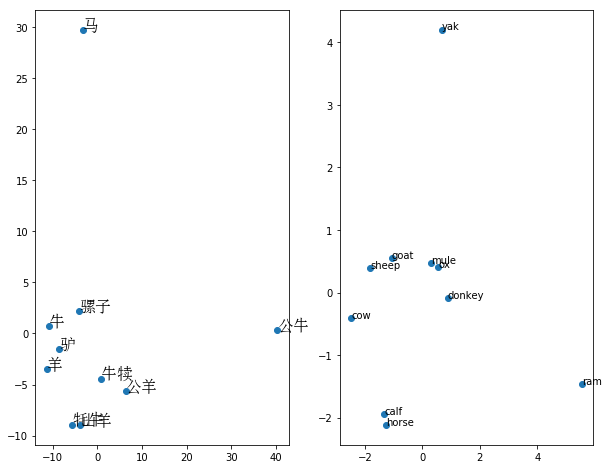

In [34]:
# 降维实现可视化
X_reduced = PCA(n_components=2).fit_transform(cn_vectors)
Y_reduced = PCA(n_components = 2).fit_transform(en_vectors)

# 绘制所有单词向量的二维空间投影
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 8))
ax1.plot(X_reduced[:, 0], X_reduced[:, 1], 'o')
ax2.plot(Y_reduced[:, 0], Y_reduced[:, 1], 'o')
#zhfont1 = matplotlib.font_manager.FontProperties(fname='/Library/Fonts/华文仿宋.ttf', size=16)
zhfont1 = matplotlib.font_manager.FontProperties(fname='C:/Windows/Fonts/simsun.ttc', size=16)
for i, w in enumerate(cn_list):
    ax1.text(X_reduced[i, 0], X_reduced[i, 1], w, fontproperties = zhfont1, alpha = 1)
for i, w in enumerate(en_list):
    ax2.text(Y_reduced[i, 0], Y_reduced[i, 1], w, alpha = 1)

## 第三步：训练一个神经网络，输入一个英文单词的词向量，输出一个中文的词向量，并翻译为中文

首先，读入一个已经建立好的词典（dictionary.txt）。本词典是老师调用百度翻译的API，自动将一篇英文小说中的词汇逐个翻译为中文而得来的

我们一个个地载入词典，并查找对应的中文词向量，如果找得到，则放入original_words中，做为正式的训练集

In [7]:
original_words = []
with open('dictionary.txt', 'r', encoding="utf8") as f:
    dataset = []
    for line in f:
        itm = line.split('\t')
        eng = itm[0]
        chn = itm[1].strip()
        if eng in word_vectors_en and chn in word_vectors:
            data = word_vectors_en[eng]
            target = word_vectors[chn]
            # 将中英文词对做成数据集
            dataset.append([data, target])
            original_words.append([eng, chn])
print(len(dataset)) # 共有4962个单词做为总的数据集合

4962


In [8]:
# 建立训练集、测试集和校验集
# 训练集用来训练神经网络，更改网络的参数；校验集用来判断网络模型是否过拟合：当校验集的损失数值超过训练集的时候，即为过拟合
# 测试集用来检验模型的好坏
indx = np.random.permutation(range(len(dataset)))
dataset = [dataset[i] for i in indx]
original_words = [original_words[i] for i in indx]
train_size = 500
train_data = dataset[train_size:]
valid_data = dataset[train_size // 2 : train_size]
test_data = dataset[: train_size // 2]
test_words = original_words[: train_size // 2]


In [13]:
# 开始训练一个多层神经网络，将一个100维度的英文向量映射为200维度的中文词向量，隐含层节点为30

input_size = 100
output_size = 200
hidden_size = 30

# 新建一个神经网络，包含一个隐含层
model = nn.Sequential(nn.Linear(input_size, hidden_size),
                     nn.Tanh(),
                     nn.Linear(hidden_size, output_size)
                     )

# 构造损失函数
criterion = torch.nn.MSELoss()

# 构造优化器
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

# 总的循环周期
num_epoch = 100


#开始训练500次，每次对所有的数据都做循环
results = []
for epoch in range(num_epoch):
    train_loss = []
    for data in train_data:
        #print(data)
        # 读入数据
        x = Variable(torch.FloatTensor(data[0])).unsqueeze(0)
        y = Variable(torch.FloatTensor(data[1])).unsqueeze(0)
        # 模型预测
        output = model(x)
        
        # 反向传播算法训练
        optimizer.zero_grad()
        loss = criterion(output, y)
        train_loss.append(loss.data.numpy()[0])
        loss.backward()
        optimizer.step()
    # 在校验集上测试一下效果
    valid_loss = []
    for data in valid_data:
        data
        x = Variable(torch.FloatTensor(data[0])).unsqueeze(0)
        y = Variable(torch.FloatTensor(data[1])).unsqueeze(0)
        output = model(x)
        loss = criterion(output, y)
        valid_loss.append(loss.data.numpy()[0])
    results.append([np.mean(train_loss), np.mean(valid_loss)])
    print('{}轮，训练Loss: {:.2f}, 校验Loss: {:.2f}'.format(epoch, np.mean(train_loss), np.mean(valid_loss)))


0轮，训练Loss: 8.75, 校验Loss: 8.42
1轮，训练Loss: 8.31, 校验Loss: 8.09
2轮，训练Loss: 8.07, 校验Loss: 7.90
3轮，训练Loss: 7.93, 校验Loss: 7.78
4轮，训练Loss: 7.82, 校验Loss: 7.69
5轮，训练Loss: 7.74, 校验Loss: 7.62
6轮，训练Loss: 7.67, 校验Loss: 7.56
7轮，训练Loss: 7.61, 校验Loss: 7.51
8轮，训练Loss: 7.56, 校验Loss: 7.46
9轮，训练Loss: 7.52, 校验Loss: 7.43
10轮，训练Loss: 7.48, 校验Loss: 7.40
11轮，训练Loss: 7.45, 校验Loss: 7.37
12轮，训练Loss: 7.42, 校验Loss: 7.35
13轮，训练Loss: 7.39, 校验Loss: 7.32
14轮，训练Loss: 7.37, 校验Loss: 7.30
15轮，训练Loss: 7.35, 校验Loss: 7.29
16轮，训练Loss: 7.33, 校验Loss: 7.27
17轮，训练Loss: 7.31, 校验Loss: 7.25
18轮，训练Loss: 7.29, 校验Loss: 7.24
19轮，训练Loss: 7.27, 校验Loss: 7.23
20轮，训练Loss: 7.26, 校验Loss: 7.22
21轮，训练Loss: 7.24, 校验Loss: 7.20
22轮，训练Loss: 7.23, 校验Loss: 7.19
23轮，训练Loss: 7.22, 校验Loss: 7.18
24轮，训练Loss: 7.21, 校验Loss: 7.18
25轮，训练Loss: 7.19, 校验Loss: 7.17
26轮，训练Loss: 7.18, 校验Loss: 7.16
27轮，训练Loss: 7.17, 校验Loss: 7.15
28轮，训练Loss: 7.16, 校验Loss: 7.14
29轮，训练Loss: 7.16, 校验Loss: 7.14
30轮，训练Loss: 7.15, 校验Loss: 7.13
31轮，训练Loss: 7.14, 校验Loss: 7.13
32轮，训练Loss: 7.13, 

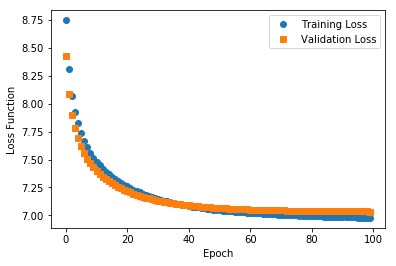

In [14]:
# 绘制图形
a = [i[0] for i in results]
b = [i[1] for i in results]
plt.plot(a, 'o', label = 'Training Loss')
plt.plot(b, 's', label = 'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Function')
plt.legend()

In [16]:
# 在测试集上验证准确度
# 检验标准有两个：一个是直接用预测的词和标准答案做全词匹配；另一个是做单字的匹配
exact_same = 0  #全词匹配数量
one_same = 0 #单字匹配数量
results = []
for i, data in enumerate(test_data):
    x = Variable(torch.FloatTensor(data[0])).unsqueeze(0)
    # 给出模型的输出
    output = model(x)
    output = output.squeeze().data.numpy()
    # 从中文词向量中找到与输出向量最相似的向量
    most_similar = word_vectors.wv.similar_by_vector(output, 1)
    # 将标准答案中的词与最相似的向量所对应的词打印出来
    results.append([original_words[i][1], most_similar[0][0]])
    
    # 全词匹配
    if original_words[i][1] == most_similar[0][0]:
        exact_same += 1
    # 某一个字匹配
    if list(set(list(original_words[i][1])) & set(list(most_similar[0][0]))) != []:
        one_same += 1
    
print("精确匹配率：{:.2f}".format(1.0 * exact_same / len(test_data)))
print('一字匹配率：{:.2f}'.format(1.0 * one_same / len(test_data)))
print(results)

精确匹配率：0.10
一字匹配率：0.20
[['像', '其实'], ['西装', '领带'], ['体积', '新增'], ['搓', '用力'], ['成长', '退化'], ['天空', '天空'], ['绑定', '降落伞'], ['吟诵', '听'], ['啊', '知道'], ['冯', '诺曼'], ['斜眼', '看到'], ['木乃伊', '木乃伊'], ['发呆', '欢乐'], ['电锯', '盾牌'], ['记忆', '神经元'], ['脆', '羽毛'], ['检查', '研究'], ['枯萎', '退化'], ['路径', '路径'], ['不断', '总是'], ['翻转', '拧'], ['拍', '扶住'], ['槽', '模块'], ['铆接', '激愤'], ['无味', '恶心'], ['下', '本身'], ['被', '因为'], ['哦', '啊'], ['学士', '英国剑桥大学'], ['手工', '邪恶'], ['迫害', '激怒'], ['等', '回家'], ['子弹', '钩子'], ['果断', '反抗'], ['银屑病', '毛发'], ['咀嚼', '咬'], ['得', '我'], ['聪明', '笨拙'], ['抱', '抱起'], ['可能', '因为'], ['服', '手套'], ['服装', '头饰'], ['目前', '建构'], ['小', '大小不一'], ['痒', '伤口'], ['后果', '可能'], ['量', '也就是说'], ['比赛', '比赛'], ['原', '原型'], ['避免', '避免'], ['毒', '毒药'], ['时钟', '按钮'], ['感觉到', '也许'], ['劳伦斯', '生物学家'], ['匆匆', '起身'], ['提高', '有效地'], ['解决', '问题'], ['无聊', '害怕'], ['你', '说'], ['女人', '她'], ['吸尘', '粘'], ['梦', '梦想'], ['突击队', '小队'], ['巴克', '兔子'], ['饿死', '死去'], ['咀嚼', '肉'], ['菜', '水果'], ['驱动', '滑行'], ['识别', '识别'], ['疲劳', '转头'], ['律师', '拒